## データセットのダウンロード

In [1]:
import os 
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

68608000/68606236 [==============================] - 2s 0us/step


## 画像の枚数を出力

In [2]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
print("training cat images:", num_cats_tr)
print("training dog images:", num_dogs_tr)

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
print("validation cat images:", num_cats_val)
print("validation dog images:", num_dogs_val)

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print("Total traing images:", total_train)
print("Total validation images:", total_val)

training cat images: 1000
training dog images: 1000
validation cat images: 500
validation dog images: 500
Total traing images: 2000
Total validation images: 1000


## ジェネレーターを生成し、画像を加工処理する

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=train_dir,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode="binary")

val_data_gen = validation_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 正解ラベルの割り当てを確認する

In [4]:
print(train_data_gen.class_indices)
print(val_data_gen.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


## 画像を可視化してみる

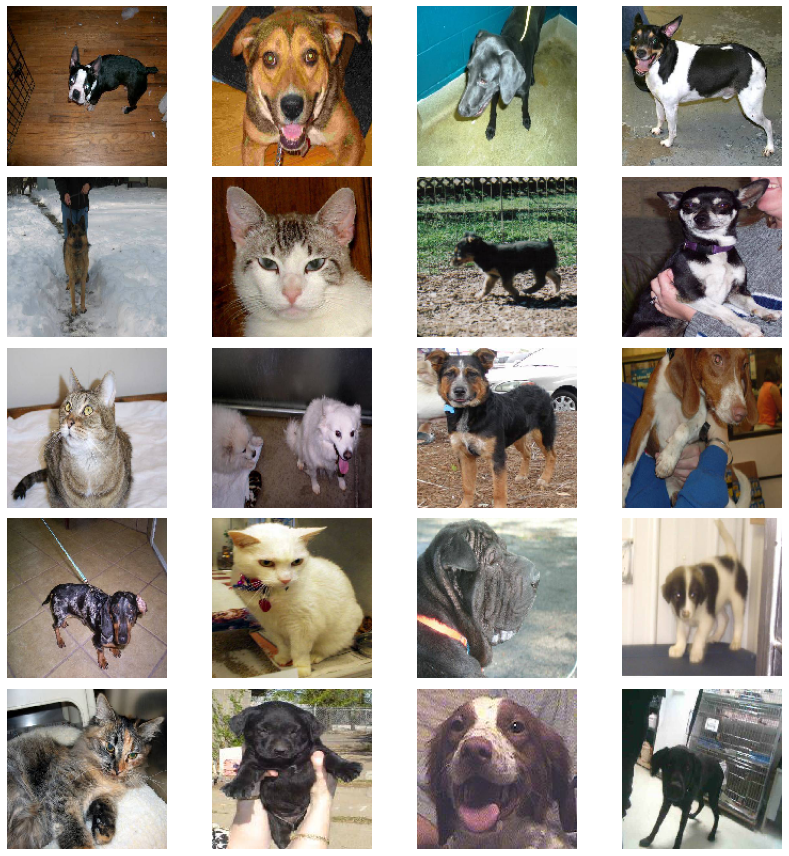

In [5]:
import matplotlib.pyplot as plt 

sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(5,4, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:20])

## ここからが本番

## データのダウンロード

In [6]:
import os 
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

#　データセットのアーカイブバージョンをダウンロードし、"/tmp/"ディレクトリに保持
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

## データジェネレーターを生成する関数の定義

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def ImageDataGenerate(train_dir, validation_dir):
        batch_size=32
        epochs = 15
        IMG_HEIGHT = 224
        IMG_WIDTH = 224

        train_image_generator = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest",
            width_shift_range=0.1,
            height_shift_range=0.1
            )
        validation_image_generator = ImageDataGenerator(rescale=1./255)

        # flow_from_directory()メソッドでディスクから画像を読み込み、
        # リスケーリングして画像を必要な大きさにリサイズ
        # 訓練データ
        train_data_gen = train_image_generator.flow_from_directory(
                batch_size=batch_size,
                directory=train_dir,
                shuffle=True,
                target_size=(IMG_HEIGHT, IMG_WIDTH),
                class_mode="binary")

        val_data_gen = validation_image_generator.flow_from_directory(
                batch_size=batch_size,
                directory=validation_dir,
                target_size=(IMG_HEIGHT, IMG_WIDTH),
                class_mode="binary")
        
        return train_data_gen, val_data_gen

## モデルの生成から学習までを実行する関数の定義

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def train_FClayer(train_data_gen, val_data_gen):
    # 画像のサイズを取得
    image_size = len(train_data_gen[0][0][0])
    # 入力データの形状をタプルにする
    input_shape = (image_size, image_size, 3)
    batch_size = len(train_data_gen[0][0])
    total_train = len(train_data_gen)*batch_size
    total_validate = len(val_data_gen)*batch_size
    
    # VGG16モデルを学習済みの重みと共に読み込む
    pre_trained_model = VGG16(
            include_top=False, # 全結合層（FC）は読み込まない
            weights="imagenet", # ImageNetで学習した重みを利用
            input_shape=input_shape)
    
    for layer in pre_trained_model.layers[:15]:
        # 第1~15層の重みを凍結
        layer.trainable = False
    for layer in pre_trained_model.layers[15:]:
        # 第16層以降の重みを更新可能にする
        layer.trainable=True
    
    model = Sequential()
    # VGG16モデルを追加
    model.add(pre_trained_model)
    
    #  (batch_size, rows, cols, channels)の4階テンソルに
    # プーリング適用後、(batch_size, channels)の2階テンソルにフラット化
    model.add(GlobalMaxPooling2D())
    
    model.add(
            Dense(512,
                         activation="relu")
    )
    model.add(Dropout(0.5))
    model.add(
            Dense(1,
                         activation="sigmoid")
    )
    
    
    # compile
    model.compile(
            loss="binary_crossentropy", 
            optimizer=optimizers.RMSprop(lr=1e-5), # Adamを使用
            metrics=["accuracy"])

    model.summary()
    
    def step_decay(epoch):
        initial_lrate = 0.00001
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(
                drop,
                math.floor((epoch)/epochs_drop)
        )
        return lrate
    
    # 学習率のコールバック
    lrate = LearningRateScheduler(step_decay)
    
    epochs = 40
    history = model.fit(
            train_data_gen,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=total_validate//batch_size,
            steps_per_epoch=total_train//batch_size,
            verbose=1,
            callbacks=[lrate]
    )
    
    return history

## 学習を行う

In [12]:
%%time

train_data_gen, val_data_gen = ImageDataGenerate(train_dir, validation_dir)
history = train_FClayer(train_data_gen, val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 7,342,593
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/40
63/63 [==============================] - 29s 446ms/step - loss: 0.6276 - accuracy: 0.6550 

## 学習の推移をグラフにする

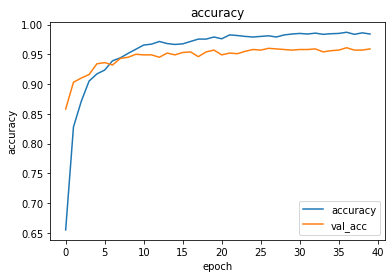

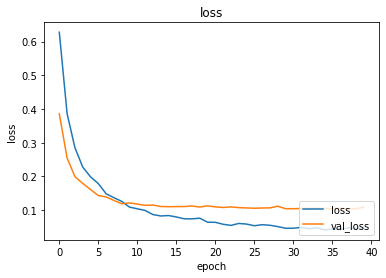

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="lower right")
    plt.show()
    
    plt.plot(history.history["loss"],label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="lower right")
    plt.show()
plot_acc_loss(history)